In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2,4,5,6,7"

# Variables
model_name = 'meta-llama/Llama-3.1-70B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_test.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_test.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 将模型移动到 GPU
    # model = nn.DataParallel(model)  # 使用 DataParallel 包装模型，支持多卡
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])  # 使用多卡进行数据并行

    hidden_states = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # 将数据移动到 GPU

        with torch.no_grad():  # 在推理时关闭梯度计算
            outputs = model(**inputs)

        # 获取最后一层的最后一个 token 的隐藏状态
        last_layer_hidden_states = outputs.hidden_states[-1]  # 最后一层的隐藏状态
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # 取最后一个 token
        hidden_states.append(last_token_hidden_states.cpu().numpy())  # 将结果转移到 CPU，并转换为 numpy 数组

    return np.vstack(hidden_states)


In [4]:
# 使用多个 GPU 进行推理
def main(texts, model, tokenizer):
    # 将模型移动到 CUDA 设备，并封装到 DataParallel 中
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = nn.DataParallel(model)  # 使用 DataParallel 进行多卡支持

    # 运行提取隐藏状态的函数
    return extract_hidden_states(texts, model, tokenizer)

In [5]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [6]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [7]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


In [ ]:
X_non_infringement = main(non_infringement_outputs, model, tokenizer)
X_infringement = main(infringement_outputs, model, tokenizer)


OutOfMemoryError: CUDA out of memory. Tried to allocate 896.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 60.75 MiB is free. Including non-PyTorch memory, this process has 79.07 GiB memory in use. Of the allocated memory 78.67 GiB is allocated by PyTorch, and 564.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   1%|          | 20/2000 [00:00<00:41, 47.60it/s]

Epoch 10/2000, Loss: 1.0688
Test Accuracy at Epoch 10: 49.68%
Test F1-score at Epoch 10: 0.1780
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.48      0.95      0.64       146
non_infringement       0.68      0.10      0.18       166

        accuracy                           0.50       312
       macro avg       0.58      0.52      0.41       312
    weighted avg       0.59      0.50      0.39       312

New best model saved with F1-score 0.1780 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.48      0.95      0.64       146
non_infringement       0.68      0.10      0.18       166

        accuracy                           0.50       312
       macro avg       0.58      0.52      0.41       312
    weighted avg       0.59      0.50      0.39       312

Epoch 20/2000, Loss: 0.5733
Test Accuracy at Epoch 20: 59.62%
Test F1-sco

Training Epochs:   2%|▏         | 40/2000 [00:00<00:28, 68.55it/s]

Epoch 30/2000, Loss: 0.5685
Test Accuracy at Epoch 30: 55.77%
Test F1-score at Epoch 30: 0.6480
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.55      0.32      0.41       146
non_infringement       0.56      0.77      0.65       166

        accuracy                           0.56       312
       macro avg       0.55      0.54      0.53       312
    weighted avg       0.55      0.56      0.53       312

Epoch 40/2000, Loss: 0.5599
Test Accuracy at Epoch 40: 58.01%
Test F1-score at Epoch 40: 0.6797
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.61      0.29      0.39       146
non_infringement       0.57      0.84      0.68       166

        accuracy                           0.58       312
       macro avg       0.59      0.56      0.54       312
    weighted avg       0.59      0.58      0.54       312



Training Epochs:   3%|▎         | 60/2000 [00:01<00:24, 78.66it/s]

Epoch 50/2000, Loss: 0.5506
Test Accuracy at Epoch 50: 57.05%
Test F1-score at Epoch 50: 0.6582
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.57      0.34      0.42       146
non_infringement       0.57      0.78      0.66       166

        accuracy                           0.57       312
       macro avg       0.57      0.56      0.54       312
    weighted avg       0.57      0.57      0.55       312

Epoch 60/2000, Loss: 0.5388
Test Accuracy at Epoch 60: 58.65%
Test F1-score at Epoch 60: 0.6427
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.57      0.46      0.51       146
non_infringement       0.59      0.70      0.64       166

        accuracy                           0.59       312
       macro avg       0.58      0.58      0.58       312
    weighted avg       0.58      0.59      0.58       312



Training Epochs:   4%|▍         | 80/2000 [00:01<00:21, 87.65it/s]

Epoch 70/2000, Loss: 0.5243
Test Accuracy at Epoch 70: 59.62%
Test F1-score at Epoch 70: 0.6379
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.54       146
non_infringement       0.61      0.67      0.64       166

        accuracy                           0.60       312
       macro avg       0.59      0.59      0.59       312
    weighted avg       0.59      0.60      0.59       312

Epoch 80/2000, Loss: 0.5036
Test Accuracy at Epoch 80: 64.42%
Test F1-score at Epoch 80: 0.6667
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       146
non_infringement       0.66      0.67      0.67       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.64      0.64      0.64       312



Training Epochs:   5%|▌         | 101/2000 [00:01<00:20, 94.19it/s]

Epoch 90/2000, Loss: 0.4867
Test Accuracy at Epoch 90: 64.42%
Test F1-score at Epoch 90: 0.6783
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.63      0.58      0.60       146
non_infringement       0.65      0.70      0.68       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.64      0.64      0.64       312

Epoch 100/2000, Loss: 0.4749
Test Accuracy at Epoch 100: 63.14%
Test F1-score at Epoch 100: 0.6526
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.61      0.61      0.61       146
non_infringement       0.65      0.65      0.65       166

        accuracy                           0.63       312
       macro avg       0.63      0.63      0.63       312
    weighted avg       0.63      0.63      0.63       312



Training Epochs:   6%|▌         | 121/2000 [00:01<00:22, 83.52it/s]

Epoch 110/2000, Loss: 0.5215
Test Accuracy at Epoch 110: 61.54%
Test F1-score at Epoch 110: 0.6178
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.58      0.65      0.61       146
non_infringement       0.66      0.58      0.62       166

        accuracy                           0.62       312
       macro avg       0.62      0.62      0.62       312
    weighted avg       0.62      0.62      0.62       312

Epoch 120/2000, Loss: 0.5075
Test Accuracy at Epoch 120: 61.54%
Test F1-score at Epoch 120: 0.6757
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.62      0.46      0.53       146
non_infringement       0.61      0.75      0.68       166

        accuracy                           0.62       312
       macro avg       0.62      0.61      0.60       312
    weighted avg       0.62      0.62      0.61       312



Training Epochs:   7%|▋         | 140/2000 [00:01<00:22, 83.33it/s]

Epoch 130/2000, Loss: 0.4972
Test Accuracy at Epoch 130: 63.78%
Test F1-score at Epoch 130: 0.6971
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.66      0.47      0.55       146
non_infringement       0.63      0.78      0.70       166

        accuracy                           0.64       312
       macro avg       0.64      0.63      0.62       312
    weighted avg       0.64      0.64      0.63       312

Epoch 140/2000, Loss: 0.4854
Test Accuracy at Epoch 140: 62.18%
Test F1-score at Epoch 140: 0.6629
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.57       146
non_infringement       0.63      0.70      0.66       166

        accuracy                           0.62       312
       macro avg       0.62      0.62      0.62       312
    weighted avg       0.62      0.62      0.62       312



Training Epochs:   8%|▊         | 160/2000 [00:02<00:21, 87.56it/s]

Epoch 150/2000, Loss: 0.4733
Test Accuracy at Epoch 150: 64.74%
Test F1-score at Epoch 150: 0.6746
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.63      0.60      0.62       146
non_infringement       0.66      0.69      0.67       166

        accuracy                           0.65       312
       macro avg       0.65      0.64      0.64       312
    weighted avg       0.65      0.65      0.65       312

Epoch 160/2000, Loss: 0.4602
Test Accuracy at Epoch 160: 64.42%
Test F1-score at Epoch 160: 0.6687
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.62      0.61      0.62       146
non_infringement       0.66      0.67      0.67       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.64      0.64      0.64       312



Training Epochs:   9%|▉         | 180/2000 [00:02<00:19, 91.67it/s]

Epoch 170/2000, Loss: 0.4466
Test Accuracy at Epoch 170: 64.74%
Test F1-score at Epoch 170: 0.6746
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.63      0.60      0.62       146
non_infringement       0.66      0.69      0.67       166

        accuracy                           0.65       312
       macro avg       0.65      0.64      0.64       312
    weighted avg       0.65      0.65      0.65       312

Epoch 180/2000, Loss: 0.4324
Test Accuracy at Epoch 180: 65.38%
Test F1-score at Epoch 180: 0.6824
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.64      0.60      0.62       146
non_infringement       0.67      0.70      0.68       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  10%|█         | 200/2000 [00:02<00:19, 92.61it/s]

Epoch 190/2000, Loss: 0.4179
Test Accuracy at Epoch 190: 62.82%
Test F1-score at Epoch 190: 0.6463
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.60      0.62      0.61       146
non_infringement       0.65      0.64      0.65       166

        accuracy                           0.63       312
       macro avg       0.63      0.63      0.63       312
    weighted avg       0.63      0.63      0.63       312

Epoch 200/2000, Loss: 0.4031
Test Accuracy at Epoch 200: 64.74%
Test F1-score at Epoch 200: 0.6687
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       146
non_infringement       0.67      0.67      0.67       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  11%|█         | 220/2000 [00:02<00:20, 87.54it/s]

Epoch 210/2000, Loss: 0.3880
Test Accuracy at Epoch 210: 64.74%
Test F1-score at Epoch 210: 0.6626
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.62      0.64      0.63       146
non_infringement       0.68      0.65      0.66       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312

Epoch 220/2000, Loss: 0.3720
Test Accuracy at Epoch 220: 64.42%
Test F1-score at Epoch 220: 0.6606
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.62      0.64      0.63       146
non_infringement       0.67      0.65      0.66       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.65      0.64      0.64       312



Training Epochs:  12%|█▏        | 239/2000 [00:03<00:19, 89.27it/s]

Epoch 230/2000, Loss: 0.3568
Test Accuracy at Epoch 230: 64.42%
Test F1-score at Epoch 230: 0.6563
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.61      0.65      0.63       146
non_infringement       0.68      0.64      0.66       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.65      0.64      0.64       312

Epoch 240/2000, Loss: 0.3421
Test Accuracy at Epoch 240: 64.42%
Test F1-score at Epoch 240: 0.6542
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.61      0.66      0.63       146
non_infringement       0.68      0.63      0.65       166

        accuracy                           0.64       312
       macro avg       0.64      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312



Training Epochs:  13%|█▎        | 267/2000 [00:03<00:19, 88.54it/s]

Epoch 250/2000, Loss: 0.3293
Test Accuracy at Epoch 250: 67.31%
Test F1-score at Epoch 250: 0.6946
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.65      0.64      0.65       146
non_infringement       0.69      0.70      0.69       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312

Epoch 260/2000, Loss: 0.3774
Test Accuracy at Epoch 260: 64.74%
Test F1-score at Epoch 260: 0.6519
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.61      0.68      0.64       146
non_infringement       0.69      0.62      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  14%|█▍        | 286/2000 [00:03<00:19, 87.84it/s]

Epoch 270/2000, Loss: 0.3202
Test Accuracy at Epoch 270: 64.42%
Test F1-score at Epoch 270: 0.6647
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       146
non_infringement       0.67      0.66      0.66       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.64      0.64      0.64       312

Epoch 280/2000, Loss: 0.3218
Test Accuracy at Epoch 280: 65.71%
Test F1-score at Epoch 280: 0.6559
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.70      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  15%|█▌        | 304/2000 [00:03<00:19, 86.39it/s]

Epoch 290/2000, Loss: 0.3090
Test Accuracy at Epoch 290: 63.46%
Test F1-score at Epoch 290: 0.6438
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.60      0.65      0.62       146
non_infringement       0.67      0.62      0.64       166

        accuracy                           0.63       312
       macro avg       0.64      0.64      0.63       312
    weighted avg       0.64      0.63      0.63       312

Epoch 300/2000, Loss: 0.2986
Test Accuracy at Epoch 300: 64.42%
Test F1-score at Epoch 300: 0.6542
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.61      0.66      0.63       146
non_infringement       0.68      0.63      0.65       166

        accuracy                           0.64       312
       macro avg       0.64      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312



Training Epochs:  16%|█▌        | 323/2000 [00:03<00:19, 87.69it/s]

Epoch 310/2000, Loss: 0.2900
Test Accuracy at Epoch 310: 64.74%
Test F1-score at Epoch 310: 0.6474
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.61      0.69      0.65       146
non_infringement       0.69      0.61      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312

Epoch 320/2000, Loss: 0.3376
Test Accuracy at Epoch 320: 66.35%
Test F1-score at Epoch 320: 0.6789
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.64      0.66      0.65       146
non_infringement       0.69      0.67      0.68       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  17%|█▋        | 343/2000 [00:04<00:18, 90.75it/s]

Epoch 330/2000, Loss: 0.3292
Test Accuracy at Epoch 330: 66.35%
Test F1-score at Epoch 330: 0.6580
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.62      0.73      0.67       146
non_infringement       0.72      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 340/2000, Loss: 0.3078
Test Accuracy at Epoch 340: 66.03%
Test F1-score at Epoch 340: 0.6624
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.62      0.70      0.66       146
non_infringement       0.70      0.63      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  18%|█▊        | 363/2000 [00:04<00:18, 90.91it/s]

Epoch 350/2000, Loss: 0.2953
Test Accuracy at Epoch 350: 64.74%
Test F1-score at Epoch 350: 0.6541
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.61      0.67      0.64       146
non_infringement       0.68      0.63      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312

Epoch 360/2000, Loss: 0.2876
Test Accuracy at Epoch 360: 64.42%
Test F1-score at Epoch 360: 0.6498
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.61      0.67      0.64       146
non_infringement       0.68      0.62      0.65       166

        accuracy                           0.64       312
       macro avg       0.65      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312



Training Epochs:  19%|█▉        | 382/2000 [00:04<00:18, 86.54it/s]

Epoch 370/2000, Loss: 0.2825
Test Accuracy at Epoch 370: 66.03%
Test F1-score at Epoch 370: 0.6603
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.62      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 380/2000, Loss: 0.3087
Test Accuracy at Epoch 380: 66.03%
Test F1-score at Epoch 380: 0.6748
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.63      0.66      0.64       146
non_infringement       0.69      0.66      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  20%|█▉        | 391/2000 [00:04<00:19, 82.68it/s]

Epoch 390/2000, Loss: 0.2952
Test Accuracy at Epoch 390: 66.35%
Test F1-score at Epoch 390: 0.6557
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.62      0.73      0.67       146
non_infringement       0.72      0.60      0.66       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  20%|██        | 400/2000 [00:04<00:25, 63.94it/s]

Epoch 400/2000, Loss: 0.3033
Test Accuracy at Epoch 400: 65.38%
Test F1-score at Epoch 400: 0.6582
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.62      0.68      0.65       146
non_infringement       0.69      0.63      0.66       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  21%|██        | 420/2000 [00:06<01:18, 20.10it/s]

Epoch 410/2000, Loss: 0.2922
Test Accuracy at Epoch 410: 66.03%
Test F1-score at Epoch 410: 0.6624
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.62      0.70      0.66       146
non_infringement       0.70      0.63      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 420/2000, Loss: 0.2811
Test Accuracy at Epoch 420: 66.03%
Test F1-score at Epoch 420: 0.6581
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  22%|██▏       | 436/2000 [00:07<00:49, 31.49it/s]

Epoch 430/2000, Loss: 0.2891
Test Accuracy at Epoch 430: 64.74%
Test F1-score at Epoch 430: 0.6541
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.61      0.67      0.64       146
non_infringement       0.68      0.63      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312

Epoch 440/2000, Loss: 0.2735
Test Accuracy at Epoch 440: 65.06%
Test F1-score at Epoch 440: 0.6540
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.61      0.68      0.65       146
non_infringement       0.69      0.62      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  23%|██▎       | 463/2000 [00:07<00:26, 57.79it/s]

Epoch 450/2000, Loss: 0.2679
Test Accuracy at Epoch 450: 64.42%
Test F1-score at Epoch 450: 0.6542
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.61      0.66      0.63       146
non_infringement       0.68      0.63      0.65       166

        accuracy                           0.64       312
       macro avg       0.64      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312

Epoch 460/2000, Loss: 0.2633
Test Accuracy at Epoch 460: 65.38%
Test F1-score at Epoch 460: 0.6582
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.62      0.68      0.65       146
non_infringement       0.69      0.63      0.66       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  24%|██▍       | 479/2000 [00:07<00:23, 64.58it/s]

Epoch 470/2000, Loss: 0.2607
Test Accuracy at Epoch 470: 66.99%
Test F1-score at Epoch 470: 0.6667
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.63      0.73      0.67       146
non_infringement       0.72      0.62      0.67       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 480/2000, Loss: 0.2709
Test Accuracy at Epoch 480: 65.38%
Test F1-score at Epoch 480: 0.6604
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.62      0.68      0.65       146
non_infringement       0.69      0.63      0.66       166

        accuracy                           0.65       312
       macro avg       0.65      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  25%|██▌       | 507/2000 [00:07<00:19, 78.09it/s]

Epoch 490/2000, Loss: 0.2843
Test Accuracy at Epoch 490: 65.71%
Test F1-score at Epoch 490: 0.6625
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.62      0.68      0.65       146
non_infringement       0.70      0.63      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 500/2000, Loss: 0.2662
Test Accuracy at Epoch 500: 65.71%
Test F1-score at Epoch 500: 0.6515
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.61      0.72      0.66       146
non_infringement       0.71      0.60      0.65       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  26%|██▌       | 524/2000 [00:08<00:19, 76.16it/s]

Epoch 510/2000, Loss: 0.2780
Test Accuracy at Epoch 510: 62.50%
Test F1-score at Epoch 510: 0.6286
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.59      0.66      0.62       146
non_infringement       0.66      0.60      0.63       166

        accuracy                           0.62       312
       macro avg       0.63      0.63      0.62       312
    weighted avg       0.63      0.62      0.63       312

Epoch 520/2000, Loss: 0.2718
Test Accuracy at Epoch 520: 65.06%
Test F1-score at Epoch 520: 0.6403
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.66       146
non_infringement       0.71      0.58      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  27%|██▋       | 543/2000 [00:08<00:17, 82.48it/s]

Epoch 530/2000, Loss: 0.2500
Test Accuracy at Epoch 530: 66.67%
Test F1-score at Epoch 530: 0.6645
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.62      0.72      0.67       146
non_infringement       0.72      0.62      0.66       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312

Epoch 540/2000, Loss: 0.2835
Test Accuracy at Epoch 540: 67.31%
Test F1-score at Epoch 540: 0.6667
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.63      0.74      0.68       146
non_infringement       0.73      0.61      0.67       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.68      0.67      0.67       312



Training Epochs:  28%|██▊       | 552/2000 [00:08<00:18, 77.08it/s]

Epoch 550/2000, Loss: 0.2477
Test Accuracy at Epoch 550: 66.67%
Test F1-score at Epoch 550: 0.6601
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.62      0.73      0.67       146
non_infringement       0.72      0.61      0.66       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312



Training Epochs:  28%|██▊       | 568/2000 [00:09<00:34, 41.21it/s]

Epoch 560/2000, Loss: 0.2493
Test Accuracy at Epoch 560: 64.42%
Test F1-score at Epoch 560: 0.6431
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.60      0.69      0.65       146
non_infringement       0.69      0.60      0.64       166

        accuracy                           0.64       312
       macro avg       0.65      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312

Epoch 570/2000, Loss: 0.2405
Test Accuracy at Epoch 570: 65.06%
Test F1-score at Epoch 570: 0.6403
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.66       146
non_infringement       0.71      0.58      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  30%|██▉       | 595/2000 [00:09<00:21, 64.01it/s]

Epoch 580/2000, Loss: 0.2811
Test Accuracy at Epoch 580: 66.03%
Test F1-score at Epoch 580: 0.6319
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.61      0.79      0.68       146
non_infringement       0.75      0.55      0.63       166

        accuracy                           0.66       312
       macro avg       0.68      0.67      0.66       312
    weighted avg       0.68      0.66      0.66       312

Epoch 590/2000, Loss: 0.2911
Test Accuracy at Epoch 590: 64.74%
Test F1-score at Epoch 590: 0.6452
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.61      0.70      0.65       146
non_infringement       0.69      0.60      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  31%|███       | 614/2000 [00:09<00:18, 74.82it/s]

Epoch 600/2000, Loss: 0.2709
Test Accuracy at Epoch 600: 65.71%
Test F1-score at Epoch 600: 0.6469
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.67       146
non_infringement       0.72      0.59      0.65       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 610/2000, Loss: 0.2539
Test Accuracy at Epoch 610: 65.38%
Test F1-score at Epoch 610: 0.6424
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.66       146
non_infringement       0.71      0.58      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  32%|███▏      | 632/2000 [00:09<00:17, 77.21it/s]

Epoch 620/2000, Loss: 0.2442
Test Accuracy at Epoch 620: 65.38%
Test F1-score at Epoch 620: 0.6424
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.66       146
non_infringement       0.71      0.58      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312

Epoch 630/2000, Loss: 0.2411
Test Accuracy at Epoch 630: 65.38%
Test F1-score at Epoch 630: 0.6424
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.66       146
non_infringement       0.71      0.58      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  33%|███▎      | 652/2000 [00:10<00:15, 85.31it/s]

Epoch 640/2000, Loss: 0.2366
Test Accuracy at Epoch 640: 64.42%
Test F1-score at Epoch 640: 0.6312
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.60      0.73      0.66       146
non_infringement       0.70      0.57      0.63       166

        accuracy                           0.64       312
       macro avg       0.65      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312

Epoch 650/2000, Loss: 0.2333
Test Accuracy at Epoch 650: 64.42%
Test F1-score at Epoch 650: 0.6312
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.60      0.73      0.66       146
non_infringement       0.70      0.57      0.63       166

        accuracy                           0.64       312
       macro avg       0.65      0.65      0.64       312
    weighted avg       0.65      0.64      0.64       312



Training Epochs:  34%|███▎      | 670/2000 [00:10<00:18, 73.56it/s]

Epoch 660/2000, Loss: 0.2332
Test Accuracy at Epoch 660: 65.71%
Test F1-score at Epoch 660: 0.6421
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.61      0.75      0.67       146
non_infringement       0.72      0.58      0.64       166

        accuracy                           0.66       312
       macro avg       0.67      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 670/2000, Loss: 0.4982
Test Accuracy at Epoch 670: 66.35%
Test F1-score at Epoch 670: 0.6367
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.61      0.79      0.69       146
non_infringement       0.75      0.55      0.64       166

        accuracy                           0.66       312
       macro avg       0.68      0.67      0.66       312
    weighted avg       0.68      0.66      0.66       312



Training Epochs:  34%|███▍      | 685/2000 [00:10<00:26, 48.85it/s]

Epoch 680/2000, Loss: 0.3317
Test Accuracy at Epoch 680: 65.71%
Test F1-score at Epoch 680: 0.6559
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.70      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  35%|███▌      | 700/2000 [00:11<00:23, 54.78it/s]

Epoch 690/2000, Loss: 0.3240
Test Accuracy at Epoch 690: 65.71%
Test F1-score at Epoch 690: 0.6581
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.62      0.70      0.66       146
non_infringement       0.70      0.62      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 700/2000, Loss: 0.3011
Test Accuracy at Epoch 700: 66.35%
Test F1-score at Epoch 700: 0.6645
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.63      0.66       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  36%|███▌      | 710/2000 [00:11<00:20, 64.10it/s]

Epoch 710/2000, Loss: 0.2839
Test Accuracy at Epoch 710: 64.74%
Test F1-score at Epoch 710: 0.6497
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.61      0.68      0.65       146
non_infringement       0.69      0.61      0.65       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  37%|███▋      | 731/2000 [00:11<00:30, 41.04it/s]

Epoch 720/2000, Loss: 0.2924
Test Accuracy at Epoch 720: 66.99%
Test F1-score at Epoch 720: 0.6508
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.62      0.77      0.69       146
non_infringement       0.74      0.58      0.65       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 730/2000, Loss: 0.2858
Test Accuracy at Epoch 730: 65.71%
Test F1-score at Epoch 730: 0.6537
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.61      0.65       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  38%|███▊      | 750/2000 [00:12<00:21, 58.84it/s]

Epoch 740/2000, Loss: 0.2765
Test Accuracy at Epoch 740: 65.71%
Test F1-score at Epoch 740: 0.6581
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.62      0.70      0.66       146
non_infringement       0.70      0.62      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 750/2000, Loss: 0.3147
Test Accuracy at Epoch 750: 65.38%
Test F1-score at Epoch 750: 0.6646
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.62      0.66      0.64       146
non_infringement       0.69      0.64      0.66       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  39%|███▉      | 777/2000 [00:12<00:16, 74.87it/s]

Epoch 760/2000, Loss: 0.4212
Test Accuracy at Epoch 760: 65.71%
Test F1-score at Epoch 760: 0.6603
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.62      0.69      0.65       146
non_infringement       0.70      0.63      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 770/2000, Loss: 0.5759
Test Accuracy at Epoch 770: 57.05%
Test F1-score at Epoch 770: 0.6667
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.58      0.30      0.40       146
non_infringement       0.57      0.81      0.67       166

        accuracy                           0.57       312
       macro avg       0.57      0.55      0.53       312
    weighted avg       0.57      0.57      0.54       312



Training Epochs:  40%|███▉      | 795/2000 [00:12<00:15, 78.75it/s]

Epoch 780/2000, Loss: 0.3762
Test Accuracy at Epoch 780: 66.03%
Test F1-score at Epoch 780: 0.6581
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 790/2000, Loss: 0.4174
Test Accuracy at Epoch 790: 63.46%
Test F1-score at Epoch 790: 0.6323
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.60      0.68      0.64       146
non_infringement       0.68      0.59      0.63       166

        accuracy                           0.63       312
       macro avg       0.64      0.64      0.63       312
    weighted avg       0.64      0.63      0.63       312



Training Epochs:  41%|████      | 813/2000 [00:12<00:15, 78.43it/s]

Epoch 800/2000, Loss: 0.3126
Test Accuracy at Epoch 800: 68.27%
Test F1-score at Epoch 800: 0.6857
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.64      0.72      0.68       146
non_infringement       0.72      0.65      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 810/2000, Loss: 0.3114
Test Accuracy at Epoch 810: 65.38%
Test F1-score at Epoch 810: 0.6327
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.60      0.76      0.67       146
non_infringement       0.73      0.56      0.63       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.67      0.65      0.65       312



Training Epochs:  42%|████▏     | 831/2000 [00:13<00:14, 81.59it/s]

Epoch 820/2000, Loss: 0.3040
Test Accuracy at Epoch 820: 66.03%
Test F1-score at Epoch 820: 0.6667
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.62      0.68      0.65       146
non_infringement       0.70      0.64      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 830/2000, Loss: 0.2881
Test Accuracy at Epoch 830: 65.71%
Test F1-score at Epoch 830: 0.6537
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.61      0.65       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  43%|████▎     | 851/2000 [00:13<00:13, 87.35it/s]

Epoch 840/2000, Loss: 0.2864
Test Accuracy at Epoch 840: 66.99%
Test F1-score at Epoch 840: 0.6667
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.63      0.73      0.67       146
non_infringement       0.72      0.62      0.67       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 850/2000, Loss: 0.2834
Test Accuracy at Epoch 850: 65.71%
Test F1-score at Epoch 850: 0.6687
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.63      0.66      0.64       146
non_infringement       0.69      0.65      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  44%|████▎     | 870/2000 [00:13<00:12, 90.64it/s]

Epoch 860/2000, Loss: 0.2934
Test Accuracy at Epoch 860: 66.99%
Test F1-score at Epoch 860: 0.6555
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.62      0.76      0.68       146
non_infringement       0.74      0.59      0.66       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 870/2000, Loss: 0.2745
Test Accuracy at Epoch 870: 66.35%
Test F1-score at Epoch 870: 0.6729
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.63      0.68      0.65       146
non_infringement       0.70      0.65      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  44%|████▍     | 889/2000 [00:13<00:14, 75.67it/s]

Epoch 880/2000, Loss: 0.2920
Test Accuracy at Epoch 880: 66.03%
Test F1-score at Epoch 880: 0.6419
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.61      0.76      0.68       146
non_infringement       0.73      0.57      0.64       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 890/2000, Loss: 0.2775
Test Accuracy at Epoch 890: 66.99%
Test F1-score at Epoch 890: 0.6555
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.62      0.76      0.68       146
non_infringement       0.74      0.59      0.66       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.68      0.67      0.67       312



Training Epochs:  46%|████▌     | 911/2000 [00:14<00:24, 43.60it/s]

Epoch 900/2000, Loss: 0.2715
Test Accuracy at Epoch 900: 66.67%
Test F1-score at Epoch 900: 0.6750
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.63      0.68      0.66       146
non_infringement       0.70      0.65      0.68       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312

Epoch 910/2000, Loss: 0.2685
Test Accuracy at Epoch 910: 68.27%
Test F1-score at Epoch 910: 0.6817
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.64      0.68       166

        accuracy                           0.68       312
       macro avg       0.69      0.69      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  46%|████▋     | 929/2000 [00:14<00:17, 60.36it/s]

Epoch 920/2000, Loss: 0.5124
Test Accuracy at Epoch 920: 65.71%
Test F1-score at Epoch 920: 0.6348
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.61      0.77      0.68       146
non_infringement       0.73      0.56      0.63       166

        accuracy                           0.66       312
       macro avg       0.67      0.66      0.66       312
    weighted avg       0.67      0.66      0.65       312

Epoch 930/2000, Loss: 0.3107
Test Accuracy at Epoch 930: 66.03%
Test F1-score at Epoch 930: 0.6467
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.61      0.75      0.67       146
non_infringement       0.72      0.58      0.65       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  48%|████▊     | 957/2000 [00:15<00:13, 74.71it/s]

Epoch 940/2000, Loss: 0.2762
Test Accuracy at Epoch 940: 64.10%
Test F1-score at Epoch 940: 0.6387
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.60      0.69      0.64       146
non_infringement       0.69      0.60      0.64       166

        accuracy                           0.64       312
       macro avg       0.64      0.64      0.64       312
    weighted avg       0.65      0.64      0.64       312

Epoch 950/2000, Loss: 0.2710
Test Accuracy at Epoch 950: 65.38%
Test F1-score at Epoch 950: 0.6516
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.61      0.71      0.66       146
non_infringement       0.70      0.61      0.65       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  49%|████▉     | 977/2000 [00:15<00:12, 84.00it/s]

Epoch 960/2000, Loss: 0.2631
Test Accuracy at Epoch 960: 66.03%
Test F1-score at Epoch 960: 0.6513
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.67       146
non_infringement       0.72      0.60      0.65       166

        accuracy                           0.66       312
       macro avg       0.67      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 970/2000, Loss: 0.2636
Test Accuracy at Epoch 970: 64.74%
Test F1-score at Epoch 970: 0.6309
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.60      0.74      0.66       146
non_infringement       0.71      0.57      0.63       166

        accuracy                           0.65       312
       macro avg       0.66      0.65      0.65       312
    weighted avg       0.66      0.65      0.65       312



Training Epochs:  49%|████▉     | 987/2000 [00:15<00:11, 87.86it/s]

Epoch 980/2000, Loss: 0.2667
Test Accuracy at Epoch 980: 67.63%
Test F1-score at Epoch 980: 0.6892
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.65      0.68      0.66       146
non_infringement       0.70      0.67      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 990/2000, Loss: 0.4063
Test Accuracy at Epoch 990: 63.14%
Test F1-score at Epoch 990: 0.6667
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.62      0.56      0.59       146
non_infringement       0.64      0.69      0.67       166

        accuracy                           0.63       312
       macro avg       0.63      0.63      0.63       312
    weighted avg       0.63      0.63      0.63       312



Training Epochs:  50%|█████     | 1006/2000 [00:15<00:12, 78.61it/s]

Epoch 1000/2000, Loss: 0.3006
Test Accuracy at Epoch 1000: 64.74%
Test F1-score at Epoch 1000: 0.6233
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.60      0.76      0.67       146
non_infringement       0.72      0.55      0.62       166

        accuracy                           0.65       312
       macro avg       0.66      0.65      0.65       312
    weighted avg       0.66      0.65      0.64       312

Epoch 1010/2000, Loss: 0.2897
Test Accuracy at Epoch 1010: 65.06%
Test F1-score at Epoch 1010: 0.6646
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.62      0.65      0.64       146
non_infringement       0.68      0.65      0.66       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  52%|█████▏    | 1033/2000 [00:16<00:11, 83.08it/s]

Epoch 1020/2000, Loss: 0.2726
Test Accuracy at Epoch 1020: 67.63%
Test F1-score at Epoch 1020: 0.6645
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.63      0.76      0.69       146
non_infringement       0.74      0.60      0.66       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 1030/2000, Loss: 0.2660
Test Accuracy at Epoch 1030: 66.99%
Test F1-score at Epoch 1030: 0.6623
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.62      0.74      0.68       146
non_infringement       0.73      0.61      0.66       166

        accuracy                           0.67       312
       macro avg       0.68      0.67      0.67       312
    weighted avg       0.68      0.67      0.67       312



Training Epochs:  53%|█████▎    | 1051/2000 [00:16<00:11, 82.14it/s]

Epoch 1040/2000, Loss: 0.2603
Test Accuracy at Epoch 1040: 67.95%
Test F1-score at Epoch 1040: 0.6774
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.63      0.68       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 1050/2000, Loss: 0.2571
Test Accuracy at Epoch 1050: 68.59%
Test F1-score at Epoch 1050: 0.6918
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.65      0.71      0.68       146
non_infringement       0.72      0.66      0.69       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  53%|█████▎    | 1068/2000 [00:16<00:16, 57.03it/s]

Epoch 1060/2000, Loss: 0.2549
Test Accuracy at Epoch 1060: 68.59%
Test F1-score at Epoch 1060: 0.6918
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.65      0.71      0.68       146
non_infringement       0.72      0.66      0.69       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1070/2000, Loss: 0.2525
Test Accuracy at Epoch 1070: 67.95%
Test F1-score at Epoch 1070: 0.6774
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.63      0.68       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  55%|█████▍    | 1094/2000 [00:17<00:23, 38.70it/s]

Epoch 1080/2000, Loss: 0.2794
Test Accuracy at Epoch 1080: 67.31%
Test F1-score at Epoch 1080: 0.6577
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.62      0.77      0.69       146
non_infringement       0.74      0.59      0.66       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.69      0.67      0.67       312

Epoch 1090/2000, Loss: 0.4481
Test Accuracy at Epoch 1090: 69.55%
Test F1-score at Epoch 1090: 0.7147
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.68      0.67      0.67       146
non_infringement       0.71      0.72      0.71       166

        accuracy                           0.70       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.70      0.70      0.70       312

New best model saved

Training Epochs:  56%|█████▌    | 1111/2000 [00:17<00:16, 52.79it/s]

Epoch 1100/2000, Loss: 0.4874
Test Accuracy at Epoch 1100: 63.78%
Test F1-score at Epoch 1100: 0.6781
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.63      0.55      0.59       146
non_infringement       0.64      0.72      0.68       166

        accuracy                           0.64       312
       macro avg       0.64      0.63      0.63       312
    weighted avg       0.64      0.64      0.64       312

Epoch 1110/2000, Loss: 0.3679
Test Accuracy at Epoch 1110: 65.06%
Test F1-score at Epoch 1110: 0.6280
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.60      0.76      0.67       146
non_infringement       0.72      0.55      0.63       166

        accuracy                           0.65       312
       macro avg       0.66      0.66      0.65       312
    weighted avg       0.67      0.65      0.65       312



Training Epochs:  57%|█████▋    | 1133/2000 [00:18<00:11, 73.36it/s]

Epoch 1120/2000, Loss: 0.3458
Test Accuracy at Epoch 1120: 67.95%
Test F1-score at Epoch 1120: 0.6855
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.64      0.71      0.67       146
non_infringement       0.72      0.66      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 1130/2000, Loss: 0.3038
Test Accuracy at Epoch 1130: 66.99%
Test F1-score at Epoch 1130: 0.6730
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.63      0.71      0.67       146
non_infringement       0.71      0.64      0.67       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312

Epoch 1140/2000, Los

Training Epochs:  58%|█████▊    | 1155/2000 [00:18<00:09, 86.57it/s]

Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.67       146
non_infringement       0.71      0.71      0.71       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1150/2000, Loss: 0.2792
Test Accuracy at Epoch 1150: 67.31%
Test F1-score at Epoch 1150: 0.6832
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.64      0.68      0.66       146
non_infringement       0.71      0.66      0.68       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 1160/2000, Loss: 0.2718
Test Accuracy at Epoch 1160: 67.95%
Test F1-score at Epoch 1160: 0.6914
Classification Repor

Training Epochs:  59%|█████▉    | 1175/2000 [00:18<00:10, 81.99it/s]

Epoch 1170/2000, Loss: 0.2698
Test Accuracy at Epoch 1170: 67.31%
Test F1-score at Epoch 1170: 0.6752
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.63      0.71      0.67       146
non_infringement       0.72      0.64      0.68       166

        accuracy                           0.67       312
       macro avg       0.68      0.68      0.67       312
    weighted avg       0.68      0.67      0.67       312

Epoch 1180/2000, Loss: 0.2706
Test Accuracy at Epoch 1180: 68.91%
Test F1-score at Epoch 1180: 0.7155
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       146
non_infringement       0.70      0.73      0.72       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

New best model saved

Training Epochs:  60%|██████    | 1201/2000 [00:19<00:10, 73.49it/s]

Epoch 1190/2000, Loss: 0.2657
Test Accuracy at Epoch 1190: 68.59%
Test F1-score at Epoch 1190: 0.7048
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       146
non_infringement       0.70      0.70      0.70       166

        accuracy                           0.69       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1200/2000, Loss: 0.2707
Test Accuracy at Epoch 1200: 68.59%
Test F1-score at Epoch 1200: 0.6859
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.69       146
non_infringement       0.73      0.64      0.69       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  61%|██████    | 1217/2000 [00:19<00:11, 70.76it/s]

Epoch 1210/2000, Loss: 0.2598
Test Accuracy at Epoch 1210: 67.95%
Test F1-score at Epoch 1210: 0.6855
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.64      0.71      0.67       146
non_infringement       0.72      0.66      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 1220/2000, Loss: 0.2585
Test Accuracy at Epoch 1220: 70.19%
Test F1-score at Epoch 1220: 0.7273
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       146
non_infringement       0.71      0.75      0.73       166

        accuracy                           0.70       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.70      0.70       312

New best model saved

Training Epochs:  62%|██████▏   | 1236/2000 [00:19<00:09, 76.63it/s]

Epoch 1230/2000, Loss: 0.2805
Test Accuracy at Epoch 1230: 67.95%
Test F1-score at Epoch 1230: 0.6753
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.64      0.74      0.68       146
non_infringement       0.73      0.63      0.68       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 1240/2000, Loss: 0.2526
Test Accuracy at Epoch 1240: 67.95%
Test F1-score at Epoch 1240: 0.6933
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.65      0.68      0.66       146
non_infringement       0.71      0.68      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312



Training Epochs:  63%|██████▎   | 1259/2000 [00:20<00:16, 46.03it/s]

Epoch 1250/2000, Loss: 0.3033
Test Accuracy at Epoch 1250: 68.59%
Test F1-score at Epoch 1250: 0.6839
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.64      0.74      0.69       146
non_infringement       0.74      0.64      0.68       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1260/2000, Loss: 0.2636
Test Accuracy at Epoch 1260: 66.99%
Test F1-score at Epoch 1260: 0.6623
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.62      0.74      0.68       146
non_infringement       0.73      0.61      0.66       166

        accuracy                           0.67       312
       macro avg       0.68      0.67      0.67       312
    weighted avg       0.68      0.67      0.67       312



Training Epochs:  64%|██████▍   | 1284/2000 [00:20<00:11, 64.06it/s]

Epoch 1270/2000, Loss: 0.2612
Test Accuracy at Epoch 1270: 70.51%
Test F1-score at Epoch 1270: 0.7278
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       146
non_infringement       0.72      0.74      0.73       166

        accuracy                           0.71       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.71      0.70       312

New best model saved with F1-score 0.7278 at epoch 1270
Best Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       146
non_infringement       0.72      0.74      0.73       166

        accuracy                           0.71       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.71      0.70       312

Epoch 1280/2000, Loss: 0.2570
Test Accuracy at Epoch 1280: 70

Training Epochs:  65%|██████▌   | 1303/2000 [00:20<00:09, 76.92it/s]

Epoch 1290/2000, Loss: 0.2597
Test Accuracy at Epoch 1290: 68.59%
Test F1-score at Epoch 1290: 0.6818
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.64      0.75      0.69       146
non_infringement       0.74      0.63      0.68       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1300/2000, Loss: 0.2679
Test Accuracy at Epoch 1300: 70.19%
Test F1-score at Epoch 1300: 0.7207
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.68      0.68      0.68       146
non_infringement       0.72      0.72      0.72       166

        accuracy                           0.70       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.70      0.70       312



Training Epochs:  66%|██████▌   | 1320/2000 [00:21<00:09, 69.82it/s]

Epoch 1310/2000, Loss: 0.2585
Test Accuracy at Epoch 1310: 69.87%
Test F1-score at Epoch 1310: 0.7235
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       146
non_infringement       0.71      0.74      0.72       166

        accuracy                           0.70       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.70      0.70       312

Epoch 1320/2000, Loss: 0.2579
Test Accuracy at Epoch 1320: 66.03%
Test F1-score at Epoch 1320: 0.6603
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.62      0.71      0.66       146
non_infringement       0.71      0.62      0.66       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  67%|██████▋   | 1336/2000 [00:21<00:11, 59.07it/s]

Epoch 1330/2000, Loss: 0.2744
Test Accuracy at Epoch 1330: 68.27%
Test F1-score at Epoch 1330: 0.6817
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.64      0.68       166

        accuracy                           0.68       312
       macro avg       0.69      0.69      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  68%|██████▊   | 1352/2000 [00:21<00:09, 67.83it/s]

Epoch 1340/2000, Loss: 0.2560
Test Accuracy at Epoch 1340: 68.59%
Test F1-score at Epoch 1340: 0.6818
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.64      0.75      0.69       146
non_infringement       0.74      0.63      0.68       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1350/2000, Loss: 0.2443
Test Accuracy at Epoch 1350: 69.23%
Test F1-score at Epoch 1350: 0.7073
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.67      0.68      0.68       146
non_infringement       0.72      0.70      0.71       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  69%|██████▊   | 1371/2000 [00:21<00:07, 79.82it/s]

Epoch 1360/2000, Loss: 0.2934
Test Accuracy at Epoch 1360: 68.59%
Test F1-score at Epoch 1360: 0.6818
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.64      0.75      0.69       146
non_infringement       0.74      0.63      0.68       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1370/2000, Loss: 0.2427
Test Accuracy at Epoch 1370: 68.91%
Test F1-score at Epoch 1370: 0.6840
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.64      0.75      0.69       146
non_infringement       0.74      0.63      0.68       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.70      0.69      0.69       312



Training Epochs:  70%|██████▉   | 1391/2000 [00:21<00:06, 88.87it/s]

Epoch 1380/2000, Loss: 0.2397
Test Accuracy at Epoch 1380: 68.27%
Test F1-score at Epoch 1380: 0.6935
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.65      0.69      0.67       146
non_infringement       0.71      0.67      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 1390/2000, Loss: 0.2382
Test Accuracy at Epoch 1390: 67.95%
Test F1-score at Epoch 1390: 0.6774
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.63      0.68       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  70%|███████   | 1410/2000 [00:22<00:07, 75.23it/s]

Epoch 1400/2000, Loss: 0.2350
Test Accuracy at Epoch 1400: 69.55%
Test F1-score at Epoch 1400: 0.6906
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.65      0.76      0.70       146
non_infringement       0.75      0.64      0.69       166

        accuracy                           0.70       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.70      0.70       312

Epoch 1410/2000, Loss: 0.2648
Test Accuracy at Epoch 1410: 67.95%
Test F1-score at Epoch 1410: 0.7059
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.67      0.63      0.65       146
non_infringement       0.69      0.72      0.71       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312



Training Epochs:  71%|███████▏  | 1426/2000 [00:22<00:08, 65.98it/s]

Epoch 1420/2000, Loss: 0.2421
Test Accuracy at Epoch 1420: 68.91%
Test F1-score at Epoch 1420: 0.7015
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.66      0.69      0.68       146
non_infringement       0.72      0.69      0.70       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1430/2000, Loss: 0.2328
Test Accuracy at Epoch 1430: 69.87%
Test F1-score at Epoch 1430: 0.7099
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.67      0.71      0.69       146
non_infringement       0.73      0.69      0.71       166

        accuracy                           0.70       312
       macro avg       0.70      0.70      0.70       312
    weighted avg       0.70      0.70      0.70       312



Training Epochs:  73%|███████▎  | 1453/2000 [00:22<00:08, 66.44it/s]

Epoch 1440/2000, Loss: 0.2309
Test Accuracy at Epoch 1440: 67.95%
Test F1-score at Epoch 1440: 0.6894
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.65      0.69      0.67       146
non_infringement       0.71      0.67      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 1450/2000, Loss: 0.2630
Test Accuracy at Epoch 1450: 68.59%
Test F1-score at Epoch 1450: 0.6994
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       146
non_infringement       0.71      0.69      0.70       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  74%|███████▎  | 1470/2000 [00:23<00:07, 69.18it/s]

Epoch 1460/2000, Loss: 0.2387
Test Accuracy at Epoch 1460: 69.55%
Test F1-score at Epoch 1460: 0.7130
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.67      0.68      0.68       146
non_infringement       0.72      0.71      0.71       166

        accuracy                           0.70       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.70      0.70      0.70       312

Epoch 1470/2000, Loss: 0.2345
Test Accuracy at Epoch 1470: 69.55%
Test F1-score at Epoch 1470: 0.7130
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.67      0.68      0.68       146
non_infringement       0.72      0.71      0.71       166

        accuracy                           0.70       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.70      0.70      0.70       312



Training Epochs:  74%|███████▍  | 1486/2000 [00:23<00:07, 66.25it/s]

Epoch 1480/2000, Loss: 0.2272
Test Accuracy at Epoch 1480: 67.95%
Test F1-score at Epoch 1480: 0.6855
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.64      0.71      0.67       146
non_infringement       0.72      0.66      0.69       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312

Epoch 1490/2000, Loss: 0.2603
Test Accuracy at Epoch 1490: 67.63%
Test F1-score at Epoch 1490: 0.6645
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.63      0.76      0.69       146
non_infringement       0.74      0.60      0.66       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  76%|███████▌  | 1510/2000 [00:23<00:06, 73.90it/s]

Epoch 1500/2000, Loss: 0.2365
Test Accuracy at Epoch 1500: 68.59%
Test F1-score at Epoch 1500: 0.7012
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       146
non_infringement       0.71      0.69      0.70       166

        accuracy                           0.69       312
       macro avg       0.68      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1510/2000, Loss: 0.2383
Test Accuracy at Epoch 1510: 68.59%
Test F1-score at Epoch 1510: 0.7012
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       146
non_infringement       0.71      0.69      0.70       166

        accuracy                           0.69       312
       macro avg       0.68      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  76%|███████▋  | 1527/2000 [00:23<00:06, 74.05it/s]

Epoch 1520/2000, Loss: 0.2375
Test Accuracy at Epoch 1520: 67.95%
Test F1-score at Epoch 1520: 0.6732
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.63      0.75      0.69       146
non_infringement       0.74      0.62      0.67       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 1530/2000, Loss: 0.2704
Test Accuracy at Epoch 1530: 68.27%
Test F1-score at Epoch 1530: 0.6733
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.63      0.76      0.69       146
non_infringement       0.74      0.61      0.67       166

        accuracy                           0.68       312
       macro avg       0.69      0.69      0.68       312
    weighted avg       0.69      0.68      0.68       312



Training Epochs:  78%|███████▊  | 1551/2000 [00:24<00:06, 67.65it/s]

Epoch 1540/2000, Loss: 0.2247
Test Accuracy at Epoch 1540: 68.27%
Test F1-score at Epoch 1540: 0.6817
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.64      0.73      0.68       146
non_infringement       0.73      0.64      0.68       166

        accuracy                           0.68       312
       macro avg       0.69      0.69      0.68       312
    weighted avg       0.69      0.68      0.68       312

Epoch 1550/2000, Loss: 0.2223
Test Accuracy at Epoch 1550: 68.91%
Test F1-score at Epoch 1550: 0.6997
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.66      0.70      0.68       146
non_infringement       0.72      0.68      0.70       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312



Training Epochs:  78%|███████▊  | 1569/2000 [00:24<00:05, 75.35it/s]

Epoch 1560/2000, Loss: 0.2229
Test Accuracy at Epoch 1560: 68.59%
Test F1-score at Epoch 1560: 0.7012
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       146
non_infringement       0.71      0.69      0.70       166

        accuracy                           0.69       312
       macro avg       0.68      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1570/2000, Loss: 0.4966
Test Accuracy at Epoch 1570: 66.03%
Test F1-score at Epoch 1570: 0.6490
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.61      0.74      0.67       146
non_infringement       0.72      0.59      0.65       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  80%|███████▉  | 1593/2000 [00:24<00:05, 75.22it/s]

Epoch 1580/2000, Loss: 0.4300
Test Accuracy at Epoch 1580: 61.22%
Test F1-score at Epoch 1580: 0.6756
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.62      0.45      0.52       146
non_infringement       0.61      0.76      0.68       166

        accuracy                           0.61       312
       macro avg       0.61      0.60      0.60       312
    weighted avg       0.61      0.61      0.60       312

Epoch 1590/2000, Loss: 0.2990
Test Accuracy at Epoch 1590: 65.71%
Test F1-score at Epoch 1590: 0.6469
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.61      0.73      0.67       146
non_infringement       0.72      0.59      0.65       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  80%|████████  | 1610/2000 [00:25<00:05, 75.64it/s]

Epoch 1600/2000, Loss: 0.2588
Test Accuracy at Epoch 1600: 65.71%
Test F1-score at Epoch 1600: 0.6748
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.63      0.64      0.64       146
non_infringement       0.68      0.67      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 1610/2000, Loss: 0.2591
Test Accuracy at Epoch 1610: 68.27%
Test F1-score at Epoch 1610: 0.6991
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.66      0.67      0.66       146
non_infringement       0.71      0.69      0.70       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312



Training Epochs:  81%|████████▏ | 1628/2000 [00:25<00:05, 67.75it/s]

Epoch 1620/2000, Loss: 0.2495
Test Accuracy at Epoch 1620: 66.35%
Test F1-score at Epoch 1620: 0.6749
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.63      0.67      0.65       146
non_infringement       0.69      0.66      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.67      0.66      0.66       312



Training Epochs:  82%|████████▏ | 1636/2000 [00:25<00:06, 56.86it/s]

Epoch 1630/2000, Loss: 0.2457
Test Accuracy at Epoch 1630: 66.35%
Test F1-score at Epoch 1630: 0.6789
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.64      0.66      0.65       146
non_infringement       0.69      0.67      0.68       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 1640/2000, Loss: 0.2414
Test Accuracy at Epoch 1640: 65.71%
Test F1-score at Epoch 1640: 0.6728
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.63      0.65      0.64       146
non_infringement       0.68      0.66      0.67       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  83%|████████▎ | 1654/2000 [00:25<00:05, 68.24it/s]

Epoch 1650/2000, Loss: 0.2390
Test Accuracy at Epoch 1650: 65.38%
Test F1-score at Epoch 1650: 0.6687
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.62      0.65      0.64       146
non_infringement       0.68      0.66      0.67       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312

Epoch 1660/2000, Loss: 0.2376
Test Accuracy at Epoch 1660: 65.38%
Test F1-score at Epoch 1660: 0.6687
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.62      0.65      0.64       146
non_infringement       0.68      0.66      0.67       166

        accuracy                           0.65       312
       macro avg       0.65      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  84%|████████▍ | 1679/2000 [00:26<00:04, 70.62it/s]

Epoch 1670/2000, Loss: 0.2673
Test Accuracy at Epoch 1670: 66.67%
Test F1-score at Epoch 1670: 0.6867
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       146
non_infringement       0.69      0.69      0.69       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312

Epoch 1680/2000, Loss: 0.5477
Test Accuracy at Epoch 1680: 62.18%
Test F1-score at Epoch 1680: 0.6845
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.63      0.45      0.53       146
non_infringement       0.62      0.77      0.68       166

        accuracy                           0.62       312
       macro avg       0.62      0.61      0.61       312
    weighted avg       0.62      0.62      0.61       312



Training Epochs:  85%|████████▌ | 1707/2000 [00:26<00:03, 80.35it/s]

Epoch 1690/2000, Loss: 0.3014
Test Accuracy at Epoch 1690: 66.67%
Test F1-score at Epoch 1690: 0.6977
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.66      0.60      0.63       146
non_infringement       0.67      0.72      0.70       166

        accuracy                           0.67       312
       macro avg       0.67      0.66      0.66       312
    weighted avg       0.67      0.67      0.67       312

Epoch 1700/2000, Loss: 0.3238
Test Accuracy at Epoch 1700: 66.99%
Test F1-score at Epoch 1700: 0.6771
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.64      0.69      0.66       146
non_infringement       0.71      0.65      0.68       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312



Training Epochs:  86%|████████▋ | 1727/2000 [00:26<00:03, 89.12it/s]

Epoch 1710/2000, Loss: 0.2723
Test Accuracy at Epoch 1710: 69.23%
Test F1-score at Epoch 1710: 0.7126
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.67       146
non_infringement       0.71      0.72      0.71       166

        accuracy                           0.69       312
       macro avg       0.69      0.69      0.69       312
    weighted avg       0.69      0.69      0.69       312

Epoch 1720/2000, Loss: 0.2641
Test Accuracy at Epoch 1720: 68.27%
Test F1-score at Epoch 1720: 0.7080
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       146
non_infringement       0.69      0.72      0.71       166

        accuracy                           0.68       312
       macro avg       0.68      0.68      0.68       312
    weighted avg       0.68      0.68      0.68       312



Training Epochs:  87%|████████▋ | 1747/2000 [00:26<00:02, 93.51it/s]

Epoch 1730/2000, Loss: 0.2579
Test Accuracy at Epoch 1730: 66.35%
Test F1-score at Epoch 1730: 0.6809
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.64      0.65      0.64       146
non_infringement       0.69      0.67      0.68       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312

Epoch 1740/2000, Loss: 0.2540
Test Accuracy at Epoch 1740: 66.03%
Test F1-score at Epoch 1740: 0.6788
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       146
non_infringement       0.68      0.67      0.68       166

        accuracy                           0.66       312
       macro avg       0.66      0.66      0.66       312
    weighted avg       0.66      0.66      0.66       312



Training Epochs:  88%|████████▊ | 1768/2000 [00:27<00:02, 96.31it/s]

Epoch 1750/2000, Loss: 0.3287
Test Accuracy at Epoch 1750: 66.35%
Test F1-score at Epoch 1750: 0.6602
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.62      0.72      0.67       146
non_infringement       0.71      0.61      0.66       166

        accuracy                           0.66       312
       macro avg       0.67      0.67      0.66       312
    weighted avg       0.67      0.66      0.66       312

Epoch 1760/2000, Loss: 0.9334
Test Accuracy at Epoch 1760: 58.65%
Test F1-score at Epoch 1760: 0.6861
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.63      0.29      0.39       146
non_infringement       0.58      0.85      0.69       166

        accuracy                           0.59       312
       macro avg       0.60      0.57      0.54       312
    weighted avg       0.60      0.59      0.55       312



Training Epochs:  89%|████████▉ | 1779/2000 [00:27<00:02, 98.52it/s]

Epoch 1770/2000, Loss: 0.5697
Test Accuracy at Epoch 1770: 51.28%
Test F1-score at Epoch 1770: 0.2692
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.49      0.90      0.63       146
non_infringement       0.67      0.17      0.27       166

        accuracy                           0.51       312
       macro avg       0.58      0.54      0.45       312
    weighted avg       0.58      0.51      0.44       312

Epoch 1780/2000, Loss: 0.5558
Test Accuracy at Epoch 1780: 49.36%
Test F1-score at Epoch 1780: 0.2404
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.48      0.88      0.62       146
non_infringement       0.60      0.15      0.24       166

        accuracy                           0.49       312
       macro avg       0.54      0.52      0.43       312
    weighted avg       0.54      0.49      0.42       312



Training Epochs:  90%|████████▉ | 1799/2000 [00:27<00:02, 80.34it/s]

Epoch 1790/2000, Loss: 0.5320
Test Accuracy at Epoch 1790: 61.54%
Test F1-score at Epoch 1790: 0.5489
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.56      0.82      0.66       146
non_infringement       0.73      0.44      0.55       166

        accuracy                           0.62       312
       macro avg       0.65      0.63      0.61       312
    weighted avg       0.65      0.62      0.60       312

Epoch 1800/2000, Loss: 0.4971
Test Accuracy at Epoch 1800: 65.38%
Test F1-score at Epoch 1800: 0.7000
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       146
non_infringement       0.65      0.76      0.70       166

        accuracy                           0.65       312
       macro avg       0.66      0.65      0.65       312
    weighted avg       0.65      0.65      0.65       312



Training Epochs:  91%|█████████ | 1824/2000 [00:27<00:02, 73.97it/s]

Epoch 1810/2000, Loss: 0.5615
Test Accuracy at Epoch 1810: 58.01%
Test F1-score at Epoch 1810: 0.6797
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.61      0.29      0.39       146
non_infringement       0.57      0.84      0.68       166

        accuracy                           0.58       312
       macro avg       0.59      0.56      0.54       312
    weighted avg       0.59      0.58      0.54       312

Epoch 1820/2000, Loss: 0.5571
Test Accuracy at Epoch 1820: 58.97%
Test F1-score at Epoch 1820: 0.6816
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.62      0.32      0.42       146
non_infringement       0.58      0.83      0.68       166

        accuracy                           0.59       312
       macro avg       0.60      0.57      0.55       312
    weighted avg       0.60      0.59      0.56       312



Training Epochs:  92%|█████████▏| 1832/2000 [00:27<00:02, 73.62it/s]

Epoch 1830/2000, Loss: 0.5214
Test Accuracy at Epoch 1830: 63.78%
Test F1-score at Epoch 1830: 0.6781
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.63      0.55      0.59       146
non_infringement       0.64      0.72      0.68       166

        accuracy                           0.64       312
       macro avg       0.64      0.63      0.63       312
    weighted avg       0.64      0.64      0.64       312



Training Epochs:  92%|█████████▎| 1850/2000 [00:28<00:02, 59.43it/s]

Epoch 1840/2000, Loss: 0.5542
Test Accuracy at Epoch 1840: 61.22%
Test F1-score at Epoch 1840: 0.6952
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.65      0.36      0.47       146
non_infringement       0.60      0.83      0.70       166

        accuracy                           0.61       312
       macro avg       0.63      0.60      0.58       312
    weighted avg       0.62      0.61      0.59       312

Epoch 1850/2000, Loss: 0.5571
Test Accuracy at Epoch 1850: 58.65%
Test F1-score at Epoch 1850: 0.6861
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.63      0.29      0.39       146
non_infringement       0.58      0.85      0.69       166

        accuracy                           0.59       312
       macro avg       0.60      0.57      0.54       312
    weighted avg       0.60      0.59      0.55       312



Training Epochs:  93%|█████████▎| 1869/2000 [00:28<00:01, 71.58it/s]

Epoch 1860/2000, Loss: 0.5465
Test Accuracy at Epoch 1860: 58.65%
Test F1-score at Epoch 1860: 0.6861
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.63      0.29      0.39       146
non_infringement       0.58      0.85      0.69       166

        accuracy                           0.59       312
       macro avg       0.60      0.57      0.54       312
    weighted avg       0.60      0.59      0.55       312

Epoch 1870/2000, Loss: 0.5368
Test Accuracy at Epoch 1870: 58.65%
Test F1-score at Epoch 1870: 0.6861
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.63      0.29      0.39       146
non_infringement       0.58      0.85      0.69       166

        accuracy                           0.59       312
       macro avg       0.60      0.57      0.54       312
    weighted avg       0.60      0.59      0.55       312



Training Epochs:  94%|█████████▍| 1888/2000 [00:28<00:01, 71.92it/s]

Epoch 1880/2000, Loss: 0.5211
Test Accuracy at Epoch 1880: 56.41%
Test F1-score at Epoch 1880: 0.6583
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.56      0.31      0.40       146
non_infringement       0.56      0.79      0.66       166

        accuracy                           0.56       312
       macro avg       0.56      0.55      0.53       312
    weighted avg       0.56      0.56      0.54       312

Epoch 1890/2000, Loss: 0.4993
Test Accuracy at Epoch 1890: 60.90%
Test F1-score at Epoch 1890: 0.6685
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.61      0.46      0.52       146
non_infringement       0.61      0.74      0.67       166

        accuracy                           0.61       312
       macro avg       0.61      0.60      0.60       312
    weighted avg       0.61      0.61      0.60       312



Training Epochs:  95%|█████████▌| 1904/2000 [00:29<00:01, 61.09it/s]

Epoch 1900/2000, Loss: 0.4878
Test Accuracy at Epoch 1900: 59.29%
Test F1-score at Epoch 1900: 0.6501
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       146
non_infringement       0.60      0.71      0.65       166

        accuracy                           0.59       312
       macro avg       0.59      0.58      0.58       312
    weighted avg       0.59      0.59      0.59       312



Training Epochs:  96%|█████████▌| 1917/2000 [00:29<00:01, 55.74it/s]

Epoch 1910/2000, Loss: 0.5200
Test Accuracy at Epoch 1910: 62.18%
Test F1-score at Epoch 1910: 0.6488
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.60      0.58      0.59       146
non_infringement       0.64      0.66      0.65       166

        accuracy                           0.62       312
       macro avg       0.62      0.62      0.62       312
    weighted avg       0.62      0.62      0.62       312

Epoch 1920/2000, Loss: 0.5525
Test Accuracy at Epoch 1920: 66.67%
Test F1-score at Epoch 1920: 0.6810
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.64      0.66      0.65       146
non_infringement       0.69      0.67      0.68       166

        accuracy                           0.67       312
       macro avg       0.67      0.67      0.67       312
    weighted avg       0.67      0.67      0.67       312



Training Epochs:  97%|█████████▋| 1940/2000 [00:29<00:00, 65.84it/s]

Epoch 1930/2000, Loss: 0.5587
Test Accuracy at Epoch 1930: 51.28%
Test F1-score at Epoch 1930: 0.2475
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.49      0.92      0.64       146
non_infringement       0.69      0.15      0.25       166

        accuracy                           0.51       312
       macro avg       0.59      0.54      0.44       312
    weighted avg       0.60      0.51      0.43       312

Epoch 1940/2000, Loss: 0.5467
Test Accuracy at Epoch 1940: 61.54%
Test F1-score at Epoch 1940: 0.5714
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.57      0.77      0.65       146
non_infringement       0.70      0.48      0.57       166

        accuracy                           0.62       312
       macro avg       0.63      0.62      0.61       312
    weighted avg       0.64      0.62      0.61       312



Training Epochs:  98%|█████████▊| 1960/2000 [00:29<00:00, 81.29it/s]

Epoch 1950/2000, Loss: 0.5385
Test Accuracy at Epoch 1950: 65.06%
Test F1-score at Epoch 1950: 0.6450
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.61      0.71      0.66       146
non_infringement       0.70      0.60      0.64       166

        accuracy                           0.65       312
       macro avg       0.66      0.65      0.65       312
    weighted avg       0.66      0.65      0.65       312

Epoch 1960/2000, Loss: 0.5401
Test Accuracy at Epoch 1960: 51.28%
Test F1-score at Epoch 1960: 0.2475
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.49      0.92      0.64       146
non_infringement       0.69      0.15      0.25       166

        accuracy                           0.51       312
       macro avg       0.59      0.54      0.44       312
    weighted avg       0.60      0.51      0.43       312

Epoch 1970/2000, Los

Training Epochs:  99%|█████████▉| 1980/2000 [00:30<00:00, 87.93it/s]

Test Accuracy at Epoch 1970: 51.28%
Test F1-score at Epoch 1970: 0.2475
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.49      0.92      0.64       146
non_infringement       0.69      0.15      0.25       166

        accuracy                           0.51       312
       macro avg       0.59      0.54      0.44       312
    weighted avg       0.60      0.51      0.43       312

Epoch 1980/2000, Loss: 0.5438
Test Accuracy at Epoch 1980: 51.28%
Test F1-score at Epoch 1980: 0.2475
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.49      0.92      0.64       146
non_infringement       0.69      0.15      0.25       166

        accuracy                           0.51       312
       macro avg       0.59      0.54      0.44       312
    weighted avg       0.60      0.51      0.43       312



Training Epochs: 100%|██████████| 2000/2000 [00:30<00:00, 65.69it/s]
/tmp/ipykernel_1187691/3077705936.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 1990/2000, Loss: 0.5327
Test Accuracy at Epoch 1990: 56.09%
Test F1-score at Epoch 1990: 0.3744
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.52      0.92      0.66       146
non_infringement       0.77      0.25      0.37       166

        accuracy                           0.56       312
       macro avg       0.65      0.58      0.52       312
    weighted avg       0.65      0.56      0.51       312

Epoch 2000/2000, Loss: 0.5201
Test Accuracy at Epoch 2000: 58.33%
Test F1-score at Epoch 2000: 0.4538
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.53      0.88      0.66       146
non_infringement       0.75      0.33      0.45       166

        accuracy                           0.58       312
       macro avg       0.64      0.60      0.56       312
    weighted avg       0.65      0.58      0.55       312



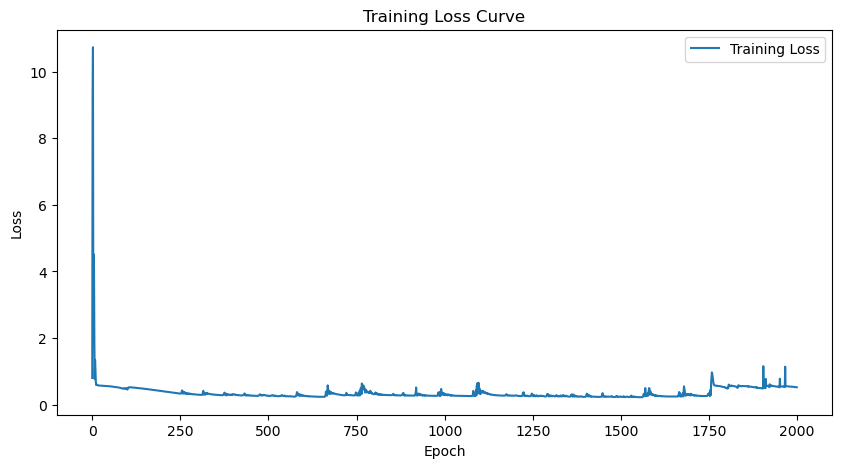

Best Model was saved at epoch 1280 with F1-score 0.7316 and accuracy 70.83%


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 70.83%
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       146
non_infringement       0.72      0.75      0.73       166

        accuracy                           0.71       312
       macro avg       0.71      0.71      0.71       312
    weighted avg       0.71      0.71      0.71       312



/tmp/ipykernel_1187691/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 